## Convolutional NN to classify govuk content to level2 taxons

Based on:
https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html

## To do:
- Consider grouping very small classes (especially if too small for evaluation)
- Split data into training, validation and test to avoid overfitting validation data during hyperparamter searches & model architecture changes
- Try learning embeddings
- Try changing pos_ratio
- Try implementing class_weights during model fit (does this do the same as the weighted binary corss entropy?)
- Work on tensorboard callbacks
- Create dictionary of class indices to taxon names for viewing results
- Check model architecture
- consider relationship of training error to validation error - overfitting/bias?
- train longer
- Try differnet max_sequence_length
- Check batch size is appropriate

### Load requirements and data

In [1]:
import pandas as pd
import numpy as np
import os
from datetime import datetime
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from keras.utils import to_categorical, layer_utils, plot_model

from keras.layers import (Embedding, Input, Dense, 
                          Activation, Conv1D, MaxPooling1D, Flatten)
from keras.models import Model, Sequential
from keras.optimizers import rmsprop
from keras.callbacks import TensorBoard, Callback
import keras.backend as K
from keras.losses import binary_crossentropy

from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score 
from sklearn.metrics import precision_recall_fscore_support, classification_report
from sklearn.utils import class_weight

import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline

import functools


Using TensorFlow backend.


### Envoronmental vars

In [2]:
DATADIR=os.getenv('DATADIR')

## Hyperparameters

In [3]:
#MAX_NB_WORDS
MAX_SEQUENCE_LENGTH =1000
EMBEDDING_DIM = 100 # used 6B.100d.txt
P_THRESHOLD = 0.5 #Threshold for probability of being assigned to class
POS_RATIO = 0.5 #ratio of positive to negative for each class in weighted binary cross entropy loss function

### Read in data
Content items tagged to level 2 taxons or lower in the topic taxonomy

In [48]:
labelled_level2 = pd.read_csv(os.path.join(DATADIR, 'labelled_level2.csv'), dtype=object)

### Create target/Y 

Note: when using the categorical_crossentropy loss, your targets should be in categorical format (e.g. if you have 10 classes, the target for each sample should be a 10-dimensional vector that is all-zeros expect for a 1 at the index corresponding to the class of the sample). In order to convert integer targets into categorical targets, you can use the Keras utility to_categorical

In [49]:
#COLLAPSE World level2taxons
labelled_level2.loc[labelled_level2['level1taxon'] == 'World', 'level2taxon'] = 'world_level1'

In [50]:
labelled_level2['level2taxon'] = labelled_level2['level2taxon'].astype('category')

labels = labelled_level2['level2taxon'].cat.codes 

In [79]:
labels_index = dict(zip((labels), labelled_level2['level2taxon']))
labels_index

{0: 'Administrative justice reform',
 1: 'Adoption, fostering and surrogacy',
 2: 'Afghanistan',
 3: 'Armed Forces Covenant',
 4: 'Armed forces',
 5: 'Armed forces and Ministry of Defence reform',
 6: 'Armed forces support for activities in the UK',
 7: 'Arts and culture',
 8: 'Assessing environmental impact',
 9: 'Asylum',
 10: 'Attorney General guidance to the legal profession',
 11: 'Aviation',
 12: 'Benefits entitlement',
 13: 'Benefits for families',
 14: 'Biodiversity and ecosystems',
 15: 'Boating and inland waterways',
 16: 'Brexit',
 17: 'Brexit and the EU',
 18: 'British citizenship ',
 19: 'British nationals overseas',
 20: 'Business and enterprise',
 21: 'Business and the environment',
 22: 'Business tax',
 23: 'Byelaws',
 24: 'Carers and disability benefits',
 25: "Carers' health",
 26: 'Certificates, register offices, changes of name or gender',
 27: 'Charities, volunteering and honours',
 28: 'Child Benefit',
 29: 'Child maintenance reform',
 30: 'Childcare and early yea

In multilabel learning, the joint set of binary classification tasks is expressed with label binary indicator array: each sample is one row of a 2d array of shape (n_samples, n_classes) with binary values:  
the one, i.e. the non zero elements, corresponds to the subset of labels.  
An array such as np.array([[1, 0, 0], [0, 1, 1], [0, 0, 0]]) represents label 0 in the first sample, labels 1 and 2 in the second sample, and no labels in the third sample.  
Producing multilabel data as a list of sets of labels may be more intuitive. The MultiLabelBinarizer transformer can be used to convert between a collection of collections of labels and the indicator format.

####  first reshape wide to get columns for each level2taxon and row number = number unique urls

In [7]:
#get a smaller copy of data for pivoting ease (think you can work from full data actually and other cols get droopedauto)

level2_reduced = labelled_level2[['content_id', 'level2taxon', 'combined_text']].copy()

#how many level2taxons are there?
print(level2_reduced.level2taxon.nunique())

#count the number of taxons per content item into new column
level2_reduced['num_taxon_per_content'] = level2_reduced.groupby(["content_id"])['content_id'].transform("count")

#Add 1 because of zero-indexing to get 1-number of level2taxons as numerical targets
level2_reduced['level2taxon_code'] = level2_reduced.level2taxon.astype('category').cat.codes + 1

210


In [8]:
#reshape to wide per taxon and keep the combined text so indexing is consistent when splitting X from Y

multilabel = (level2_reduced.pivot_table(index=['content_id', 'combined_text'], 
                  columns='level2taxon_code', 
                  values='num_taxon_per_content'))
print(level2_reduced.shape)
print(multilabel.shape)

(173560, 5)
(114048, 210)


In [9]:
#convert the number_of_taxons_per_content values to 1, meaning there was an entry for this taxon and this content_id, 0 otherwise
binary_multilabel = multilabel.notnull().astype('int')

In [10]:
#will convert columns to an array of shape
binary_multilabel[list(binary_multilabel.columns)].values.shape

(114048, 210)

In [11]:
#convert columns to an array. Each row represents a content item, each column an individual taxon
binary_multilabel = binary_multilabel[list(binary_multilabel.columns)].values
binary_multilabel[2]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0])

In [12]:
type(binary_multilabel)

numpy.ndarray

In [13]:
# mlb = MultiLabelBinarizer()
# y = mlb.fit_transform(binary_multilabel)
# y.shape

In [14]:
#Use this for singlelabel problems
# labels = to_categorical(np.asarray(labels))

# print('Shape of label tensor:', labels.shape)

# labels

### Create language data/X

format our text samples and labels into tensors that can be fed into a neural network. To do this, we will rely on Keras utilities keras.preprocessing.text.Tokenizer and keras.preprocessing.sequence.pad_sequences.

In [15]:
multilabel.index.names
texts = multilabel.index.get_level_values('combined_text')
texts.shape

(114048,)

In [16]:
tokenizer = Tokenizer(num_words=20000)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts) #yield one sequence per input text

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen= MAX_SEQUENCE_LENGTH) #MAX_SEQUENCE_LENGTH

Found 213132 unique tokens.


In [17]:
print('Shape of label tensor:', binary_multilabel.shape)
print('Shape of data tensor:', data.shape)

Shape of label tensor: (114048, 210)
Shape of data tensor: (114048, 1000)


### Data split
- Training data = 70%
- validation data = 20%
- Test data = 10%

In [18]:
# split the data into a training set and a validation set
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = binary_multilabel[indices]
nb_validation_samples = int(0.2 * data.shape[0]) #validation split
print('nb_validationsamples:', nb_validation_samples)

x_train = data[:-nb_validation_samples]
print ("number of training examples = " + str(x_train.shape[0]))

print('Shape of x_train:', x_train.shape)
y_train = labels[:-nb_validation_samples]
print('Shape of y_train:', y_train.shape)
x_val = data[-nb_validation_samples:]
print('Shape of x_val:', x_val.shape)
y_val = labels[-nb_validation_samples:]
print('Shape of y_val:', y_val.shape)

nb_validationsamples: 22809
number of training examples = 91239
Shape of x_train: (91239, 1000)
Shape of y_train: (91239, 210)
Shape of x_val: (22809, 1000)
Shape of y_val: (22809, 210)


### preparing the Embedding layer
compute an index mapping words ot known embeddings by parsing the data dump of pre-trained embeddings
NB stopwords haven't been removed yet...

In [19]:
embeddings_index = {}
f = open(os.path.join(DATADIR, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


compute embedding matrix using embedding_index dict and word_index

In [20]:
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))# used 6B.100d.txt
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

load this embedding matrix into an Embedding layer. Note that we set trainable=False to prevent the weights from being updated during training.

In [21]:
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM, # used 6B.100d.txt
                            weights=[embedding_matrix],
                            input_length= MAX_SEQUENCE_LENGTH, #MAX_SEQUENCE LENGTH
                            trainable=False)

# embedding_layer = Embedding(len(word_index) + 1, 
#                             EMBEDDING_DIM, 
#                             input_length=MAX_SEQUENCE_LENGTH)

An Embedding layer should be fed sequences of integers, i.e. a 2D input of shape (samples, indices). These input sequences should be padded so that they all have the same length in a batch of input data (although an Embedding layer is capable of processing sequence of heterogenous length, if you don't pass an explicit input_length argument to the layer).

All that the Embedding layer does is to map the integer inputs to the vectors found at the corresponding index in the embedding matrix, i.e. the sequence [1, 2] would be converted to [embeddings[1], embeddings[2]]. This means that the output of the Embedding layer will be a 3D tensor of shape (samples, sequence_length, embedding_dim).

### Estimate class weights for unbalanced datasets.
paramter to model.fit = __class_weight__: Optional dictionary mapping class indices (integers) to a weight (float) value, used for weighting the loss function (during training only). This can be useful to tell the model to "pay more attention" to samples from an under-represented class.

Implement class_weight from sklearn:

- Import the module 

`from sklearn.utils import class_weight`
- calculate the class weight, If ‘balanced’, class weights will be given by n_samples / (n_classes * np.bincount(y)):

`class_weight = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)`

- change it to a dict in order to work with Keras.

`class_weight_dict = dict(enumerate(class_weight))`

- Add to model fitting

`model.fit(X_train, y_train, class_weight=class_weight)`

In [23]:
class_weight = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
class_weight_dict = dict(enumerate(class_weight))

TypeError: unhashable type: 'numpy.ndarray'

### Custom loss function

In [25]:
class WeightedBinaryCrossEntropy(object):

    def __init__(self, pos_ratio):
        neg_ratio = 1. - pos_ratio
        #self.pos_ratio = tf.constant(pos_ratio, tf.float32)
        self.pos_ratio = pos_ratio
        #self.weights = tf.constant(neg_ratio / pos_ratio, tf.float32)
        self.weights = neg_ratio / pos_ratio
        self.__name__ = "weighted_binary_crossentropy({0})".format(pos_ratio)

    def __call__(self, y_true, y_pred):
        return self.weighted_binary_crossentropy(y_true, y_pred)

    def weighted_binary_crossentropy(self, y_true, y_pred):
            # Transform to logits
            epsilon = tf.convert_to_tensor(K.common._EPSILON, y_pred.dtype.base_dtype)
            y_pred = tf.clip_by_value(y_pred, epsilon, 1 - epsilon)
            y_pred = tf.log(y_pred / (1 - y_pred))

            cost = tf.nn.weighted_cross_entropy_with_logits(y_true, y_pred, self.weights)
            return K.mean(cost * self.pos_ratio, axis=-1)
    
y_true_arr = np.array([0,1,0,1], dtype="float32")
y_pred_arr = np.array([0,0,1,1], dtype="float32")
y_true = tf.constant(y_true_arr)
y_pred = tf.constant(y_pred_arr)

with tf.Session().as_default(): 
    print(WeightedBinaryCrossEntropy(0.5)(y_true, y_pred).eval())
    print(binary_crossentropy(y_true, y_pred).eval())


4.00756
8.01512


### difficulty getting global precision/recall metrics . CAUTION interpreting monitoring metrics
fcholltet: "Basically these are all global metrics that were approximated
batch-wise, which is more misleading than helpful. This was mentioned in
the docs but it's much cleaner to remove them altogether. It was a mistake
to merge them in the first place."

In [26]:
def mcor(y_true, y_pred):
     #matthews_correlation
     y_pred_pos = K.round(K.clip(y_pred, 0, 1))
     y_pred_neg = 1 - y_pred_pos
 
 
     y_pos = K.round(K.clip(y_true, 0, 1))
     y_neg = 1 - y_pos
 
 
     tp = K.sum(y_pos * y_pred_pos)
     tn = K.sum(y_neg * y_pred_neg)
 
 
     fp = K.sum(y_neg * y_pred_pos)
     fn = K.sum(y_pos * y_pred_neg)
 
 
     numerator = (tp * tn - fp * fn)
     denominator = K.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))
 
 
     return numerator / (denominator + K.epsilon())

def precision(y_true, y_pred):
    """Precision metric.

    Only computes a batch-wise average of precision.

    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_true, y_pred):
    """Recall metric.

    Only computes a batch-wise average of recall.

    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall))

## Training a 1D convnet

### 1. Create model

In [27]:
NB_CLASSES = y_train.shape[1]
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32') #MAX_SEQUENCE_LENGTH
embedded_sequences = embedding_layer(sequence_input)

x = Conv1D(128, 5, activation='relu', name = 'conv0')(embedded_sequences)

x = MaxPooling1D(5, name = 'max_pool0')(x)

x = Conv1D(128, 5, activation='relu', name = 'conv1')(x)

x = MaxPooling1D(5 , name = 'max_pool1')(x)

x = Conv1D(128, 5, activation='relu', name = 'conv2')(x)

x = MaxPooling1D(35, name = 'global_max_pool')(x)  # global max pooling

x = Flatten()(x) #reduce dimensions from 3 to 2; convert to vector + FULLYCONNECTED

x = Dense(128, activation='relu')(x)

x = Dense(NB_CLASSES, activation='sigmoid', name = 'fully_connected')(x)

# Create model. 
# This creates Keras model instance, will use this instance to train/test the model.
model = Model(sequence_input, x)

### 2. Compile model

In [28]:
model.compile(loss=WeightedBinaryCrossEntropy(POS_RATIO),
              optimizer='rmsprop',
              metrics=['binary_accuracy', precision, recall, f1])

Metric values are recorded at the end of each epoch on the training dataset. If a validation dataset is also provided, then the metric recorded is also calculated for the validation dataset.

All metrics are reported in verbose output and in the history object returned from calling the fit() function. In both cases, the name of the metric function is used as the key for the metric values. In the case of metrics for the validation dataset, the “val_” prefix is added to the key.

You have now built a function to describe your model. To train and test this model, there are four steps in Keras:
1. Create the model by calling the function above
2. Compile the model by calling `model.compile(optimizer = "...", loss = "...", metrics = ["accuracy"])`
3. Train the model on train data by calling `model.fit(x = ..., y = ..., epochs = ..., batch_size = ...)`
4. Test the model on test data by calling `model.evaluate(x = ..., y = ...)`

If you want to know more about `model.compile()`, `model.fit()`, `model.evaluate()` and their arguments, refer to the official [Keras documentation](https://keras.io/models/model/).


In [29]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1000)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 1000, 100)         21313300  
_________________________________________________________________
conv0 (Conv1D)               (None, 996, 128)          64128     
_________________________________________________________________
max_pool0 (MaxPooling1D)     (None, 199, 128)          0         
_________________________________________________________________
conv1 (Conv1D)               (None, 195, 128)          82048     
_________________________________________________________________
max_pool1 (MaxPooling1D)     (None, 39, 128)           0         
_________________________________________________________________
conv2 (Conv1D)               (None, 35, 128)           82048     
__________

### Tensorboard callbacks /metrics /monitor training

<span style="color:red"> **Size of these files is killing storage during training. Is it histograms?**</span>

In [30]:
tb = TensorBoard(log_dir='./multilabel_logs', histogram_freq=1, write_graph=True, write_images=False)

In [31]:
class Metrics(Callback):
    def on_train_begin(self, logs={}):
        self.val_f1s = []
        self.val_recalls = []
        self.val_precisions = []
 
    def on_epoch_end(self, epoch, logs={}):
        val_predict = (np.asarray(self.model.predict(self.model.validation_data[0]))).round()
        val_targ = self.model.validation_data[1]
        _val_f1 = f1_score(val_targ, val_predict)
        _val_recall = recall_score(val_targ, val_predict)
        _val_precision = precision_score(val_targ, val_predict)
        self.val_f1s.append(_val_f1)
        self.val_recalls.append(_val_recall)
        self.val_precisions.append(_val_precision)
        print("- val_f1: %f — val_precision: %f — val_recall %f" %(_val_f1, _val_precision, _val_recall))
        return
 
metrics = Metrics()

### 3. Train model

In [32]:
# metrics callback causes: AttributeError: 'Model' object has no attribute 'validation_data'
# So disable for now

model.fit(
    x_train, y_train, 
    validation_data=(x_val, y_val), 
    epochs=10, batch_size=128, 
    callbacks=[tb]
)

Train on 91239 samples, validate on 22809 samples
Epoch 1/10
91239/91239 [==============================] - 1101s 12ms/step - loss: 0.0157 - binary_accuracy: 0.9917 - precision: 0.5189 - recall: 0.1002 - f1: nan - val_loss: 0.0101 - val_binary_accuracy: 0.9941 - val_precision: 0.7801 - val_recall: 0.2274 - val_f1: 0.3510
Epoch 2/10
91239/91239 [==============================] - 1089s 12ms/step - loss: 0.0088 - binary_accuracy: 0.9947 - precision: 0.7628 - recall: 0.3454 - f1: 0.4722 - val_loss: 0.0077 - val_binary_accuracy: 0.9952 - val_precision: 0.8065 - val_recall: 0.4118 - val_f1: 0.5442
Epoch 3/10
91239/91239 [==============================] - 1081s 12ms/step - loss: 0.0071 - binary_accuracy: 0.9954 - precision: 0.8003 - recall: 0.4678 - f1: 0.5891 - val_loss: 0.0072 - val_binary_accuracy: 0.9955 - val_precision: 0.8071 - val_recall: 0.4754 - val_f1: 0.5974
Epoch 4/10
91239/91239 [==============================] - 1081s 12ms/step - loss: 0.0063 - binary_accuracy: 0.9959 - precisio

### Evaluate model

#### Training metrics

In [ ]:
y_pred = model.predict(x_train)

In [133]:
y_pred.shape

(91239, 210)

In [35]:
y_pred[y_pred>=P_THRESHOLD] = 1
y_pred[y_pred<P_THRESHOLD] = 0

In [36]:
f1_score(y_train, y_pred, average='micro')

0.77471105387173311

In [37]:
#average= None, the scores for each class are returned.
precision_recall_fscore_support(y_train, y_pred, average=None, sample_weight=None)

/Users/ellieking/Documents/tag_tax/govuk-taxonomy-supervised-learning/tax_SL/lib/python3.4/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


(array([ 0.        ,  0.        ,  0.97828233,  0.76923077,  0.        ,
         0.86069652,  0.        ,  0.8714653 ,  0.        ,  0.        ,
         0.        ,  0.88043478,  0.        ,  0.        ,  0.72852234,
         0.        ,  0.68965517,  0.        ,  0.        ,  0.86079295,
         0.84431494,  0.8071066 ,  0.82146893,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  1.        ,  0.87037037,
         0.72727273,  0.        ,  0.        ,  0.65740741,  0.91050793,
         0.79816514,  0.82506103,  0.71428571,  0.78494624,  0.81345566,
         0.        ,  0.89498807,  0.        ,  0.        ,  0.63829787,
         0.        ,  0.        ,  0.93835616,  0.91797346,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.91595615,  0.        ,  0.84573503,
         1.        ,  0.        ,  0.91666667,  0.88235294,  0.        ,
         0.74674115,  0.        ,  1.        ,  0.9

In [54]:
a = precision_recall_fscore_support(y_train, y_pred, average=None, sample_weight=None)

/Users/ellieking/Documents/tag_tax/govuk-taxonomy-supervised-learning/tax_SL/lib/python3.4/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [89]:
pd.DataFrame(list(a))

,0,1,2,3,4,5,6,7,8,9,...,200,201,202,203,204,205,206,207,208,209
0,0.0,0.0,0.978282,0.769231,0.0,0.860697,0.0,0.871465,0.0,0.0,...,0.834437,0.955224,0.0,0.804171,0.0,0.727273,0.0,0.0,1.000000,0.964912
1,0.0,0.0,0.900909,0.394737,0.0,0.333333,0.0,0.784268,0.0,0.0,...,0.380665,0.524590,0.0,0.837658,0.0,0.164384,0.0,0.0,0.625000,0.920130
2,0.0,0.0,0.938003,0.521739,0.0,0.480556,0.0,0.825571,0.0,0.0,...,0.522822,0.677249,0.0,0.820573,0.0,0.268156,0.0,0.0,0.769231,0.941989
3,11.0,56.0,1100.000000,152.000000,9.0,519.000000,96.0,1729.000000,5.0,22.0,...,331.000000,122.000000,3.0,1657.000000,6.0,146.000000,23.0,26.0,40.000000,1853.000000


In [105]:
f1_byclass = pd.DataFrame((a)[2], columns=['f1'])


In [106]:
support_byclass = pd.DataFrame((a)[3], columns=['support'])

f1_byclass = pd.merge(
    left=f1_byclass, 
    right=support_byclass, 
    left_index=True,
    right_index=True,
    how='outer', 
    validate='one_to_one'
)

f1_byclass['index_col'] = f1_byclass.index

In [107]:
f1_byclass['level2taxon'] = f1_byclass['index_col'].map(labels_index).copy()
f1_byclass

,f1,support,index_col,level2taxon
0,0.000000,11,0,Administrative justice reform
1,0.000000,56,1,"Adoption, fostering and surrogacy"
2,0.938003,1100,2,Afghanistan
3,0.521739,152,3,Armed Forces Covenant
4,0.000000,9,4,Armed forces
5,0.480556,519,5,Armed forces and Ministry of Defence reform
6,0.000000,96,6,Armed forces support for activities in the UK
7,0.825571,1729,7,Arts and culture
8,0.000000,5,8,Assessing environmental impact
9,0.000000,22,9,Asylum


In [140]:
print("At p_threshold of {}, there were {} out of {} ({})% taxons with auto-tagged content"
      .format(P_THRESHOLD, 
              f1_byclass.loc[f1_byclass['f1'] > 0].shape[0], 
              y_pred.shape[1], 
              (f1_byclass.loc[f1_byclass['f1'] > 0].shape[0]/y_pred.shape[1])*100 ))

At p_threshold of 0.5, there were 115 out of 210 (54.761904761904766)% taxons with auto-tagged content


In [141]:
illdefined = f1_byclass.loc[f1_byclass['f1'] == 0]
illdefined = illdefined.set_index('level2taxon')

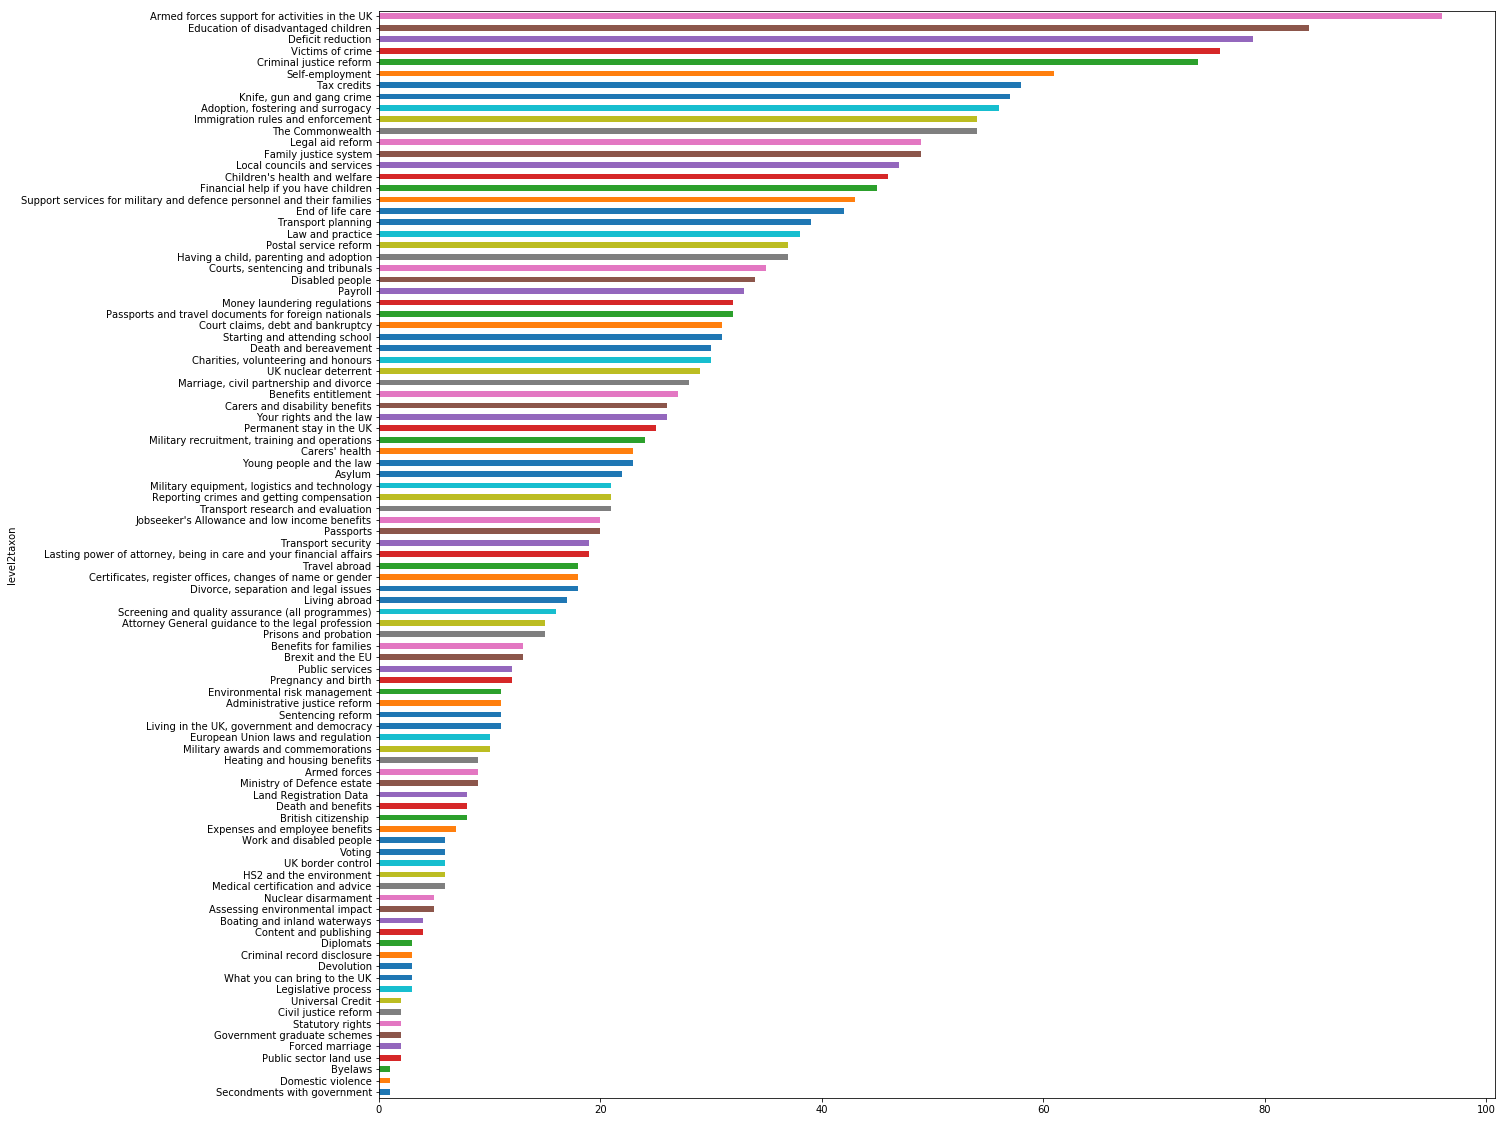

In [142]:
illdefined['support'].sort_values().plot( kind = 'barh', figsize=(20, 20))

In [143]:
classes_predictedto = f1_byclass.loc[f1_byclass['f1'] > 0]
classes_predictedto = classes_predictedto.set_index('level2taxon')

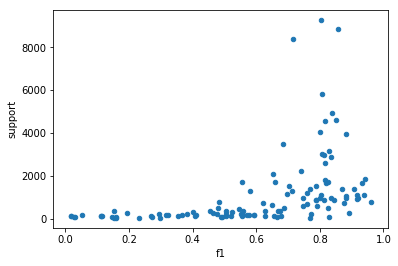

In [145]:
classes_predictedto.plot.scatter(x='f1', y='support')

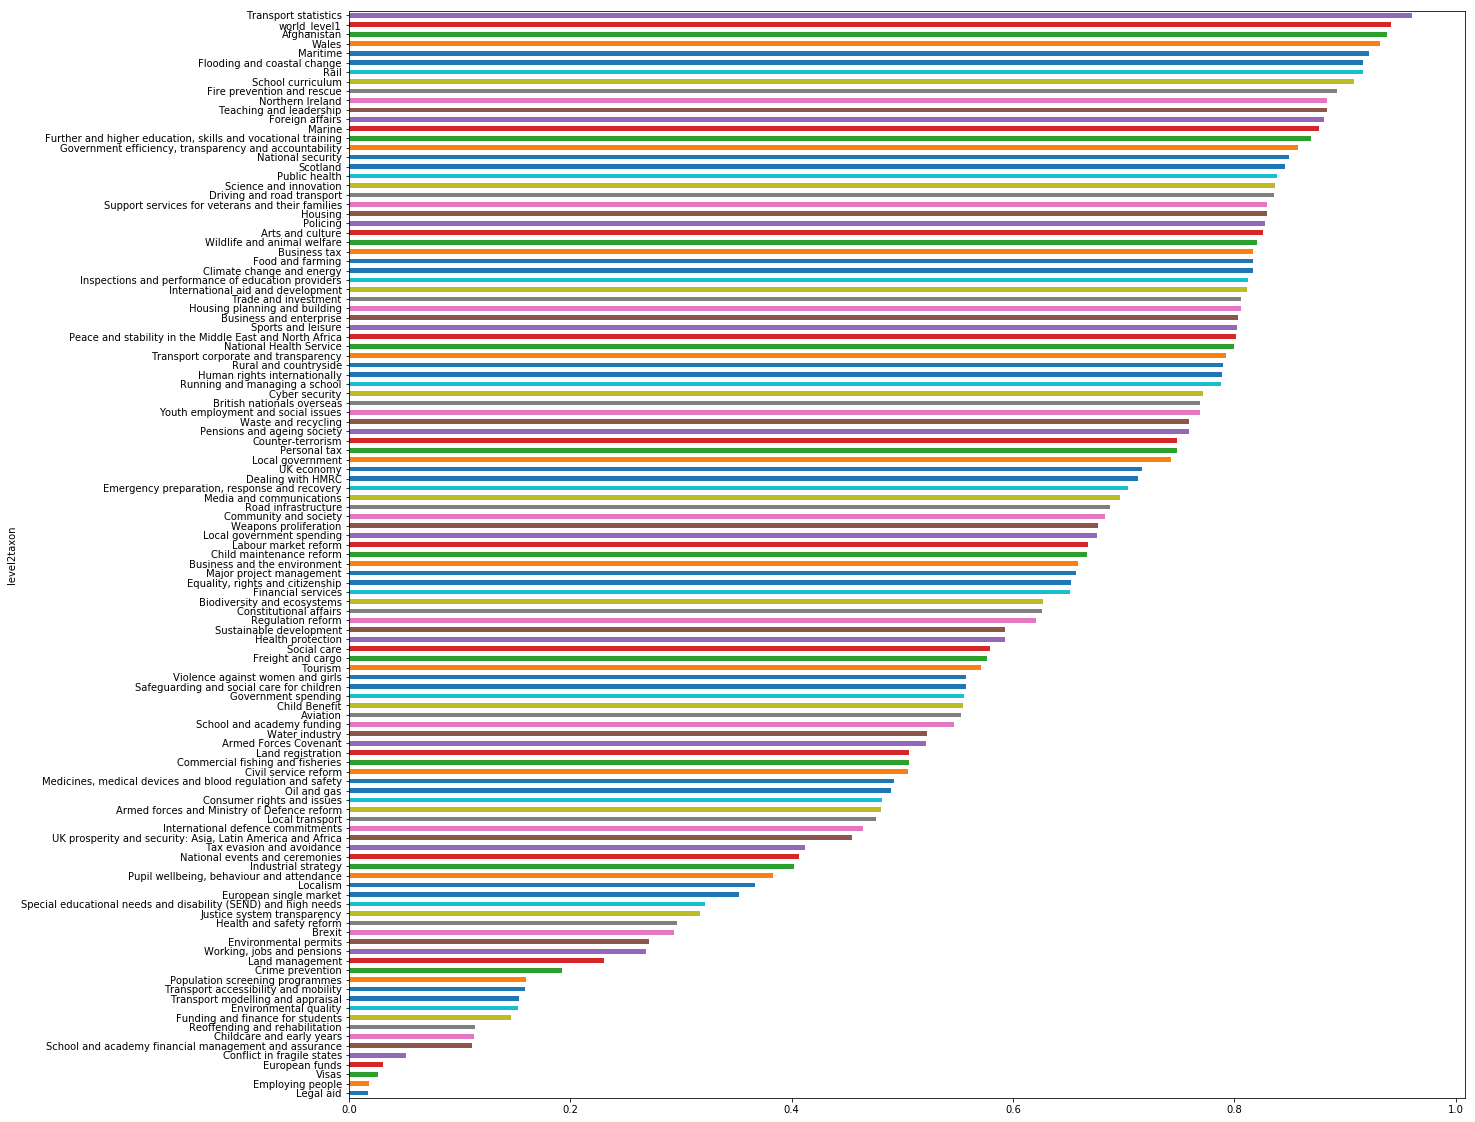

In [146]:
classes_predictedto['f1'].sort_values().plot( kind = 'barh', figsize=(20, 20))

In [87]:
#Calculate globally by counting the total true positives, false negatives and false positives.
precision_recall_fscore_support(y_train, y_pred, average='micro', sample_weight=None) 

(0.87289914986142092, 0.69637885082116113, 0.77471105387173311, None)

In [39]:
#Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account
precision_recall_fscore_support(y_train, y_pred, average='macro', sample_weight=None)

/Users/ellieking/Documents/tag_tax/govuk-taxonomy-supervised-learning/tax_SL/lib/python3.4/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


(0.47197293041373406, 0.28470325253722589, 0.33016279134606186, None)

#### Validation metrics

In [40]:
y_pred_val = model.predict(x_val)

In [41]:
y_pred_val[y_pred_val>=P_THRESHOLD] = 1
y_pred_val[y_pred_val<P_THRESHOLD] = 0

In [43]:
#average= None, the scores for each class are returned.
precision_recall_fscore_support(y_val, y_pred_val, average=None, sample_weight=None)

/Users/ellieking/Documents/tag_tax/govuk-taxonomy-supervised-learning/tax_SL/lib/python3.4/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/ellieking/Documents/tag_tax/govuk-taxonomy-supervised-learning/tax_SL/lib/python3.4/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


(array([ 0.        ,  0.        ,  0.93775934,  0.5       ,  0.        ,
         0.6       ,  0.        ,  0.78894472,  0.        ,  0.        ,
         0.        ,  0.76470588,  0.        ,  0.        ,  0.48333333,
         0.        ,  0.3       ,  0.        ,  0.        ,  0.75      ,
         0.75974026,  0.66015625,  0.70379147,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  1.        ,  0.66666667,
         0.5       ,  0.        ,  0.        ,  0.39622642,  0.83957845,
         0.51851852,  0.72089041,  1.        ,  0.5       ,  0.46153846,
         0.        ,  0.66197183,  0.        ,  0.        ,  0.29411765,
         0.        ,  0.        ,  0.85714286,  0.80319149,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.73142857,  0.        ,  0.72727273,
         0.        ,  0.        ,  0.        ,  0.625     ,  0.        ,
         0.63716814,  0.        ,  1.        ,  0.3

In [44]:
#Calculate globally by counting the total true positives, false negatives and false positives.
precision_recall_fscore_support(y_val, y_pred_val, average='micro', sample_weight=None) 

(0.78140344094335978, 0.59946611300608033, 0.67844914400805634, None)

In [45]:
#Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account
precision_recall_fscore_support(y_val, y_pred_val, average='macro', sample_weight=None)

/Users/ellieking/Documents/tag_tax/govuk-taxonomy-supervised-learning/tax_SL/lib/python3.4/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/ellieking/Documents/tag_tax/govuk-taxonomy-supervised-learning/tax_SL/lib/python3.4/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


(0.37480943520284948, 0.22834536637549022, 0.26643755724626694, None)

Improve accuracy by training longer with some regularization mechanism (such as dropout) or by fine-tuning the Embedding layer.

We can also test how well we would have performed by not using pre-trained word embeddings, but instead initializing our Embedding layer from scratch and learning its weights during training. We just need to replace our Embedding layer with the following:

embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            input_length=MAX_SEQUENCE_LENGTH)
                            
After 2 epochs, this approach only gets us to 90% validation accuracy, less than what the previous model could reach in just one epoch. Our pre-trained embeddings were definitely buying us something. In general, using pre-trained embeddings is relevant for natural processing tasks were little training data is available (functionally the embeddings act as an injection of outside information which might prove useful for your model).



In [ ]:
# Build a classifier optimized for maximizing f1_score (uses class_weights)
# from keras.layers import Dropout

# clf = Sequential()

# clf.add(Dense(x_train.shape[1], 1600, activation='relu'))
# clf.add(Dropout(0.6))
# clf.add(Dense(1600, 1200, activation='relu'))
# clf.add(Dropout(0.6))
# clf.add(Dense(1200, 800, activation='relu'))
# clf.add(Dropout(0.6))
# clf.add(Dense(800, y_train.shape[1], activation='sigmoid'))

# clf.compile(optimizer=Adam(), loss='binary_crossentropy')

# clf.fit(xt, yt, batch_size=64, nb_epoch=300, validation_data=(xs, ys), class_weight=W, verbose=0)

# preds = clf.predict(xs)

# preds[preds>=0.5] = 1
# preds[preds<0.5] = 0

# print(f1_score(ys, preds, average='macro'))